https://www.kaggle.com/marto24/keras-baseline-model-88

In [1]:
import pandas as pd
import numpy as np
import json

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from sklearn import set_config
set_config(print_changed_only = False)

import tensorflow as tf
from tensorflow.keras import layers, Sequential
from sklearn.utils import class_weight, shuffle

import warnings
warnings.filterwarnings("ignore")

### train. test data importing

In [2]:
Train = pd.read_csv("Desktop/phthon/cassava-leaf-disease-classification/train.csv")
Test = pd.read_csv("Desktop/phthon/cassava-leaf-disease-classification/sample_submission.csv")

print(Train.shape)
print(Test.shape)
Train.head()

(21397, 2)
(1, 2)


,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


### json data importing & analysis

**train 테이블에서는 label이 존재. 이 label은 결과값인데 실제 사진에는 없기 때문에 이를 확장하는 작업이 필요함**

In [3]:
with open("Desktop/phthon/cassava-leaf-disease-classification/label_num_to_disease_map.json") as f:
    data = json.load(f)

print(data)

# data 체크 결과 각 label에 해당하는 state를 말해줌으로, train 데이터에 merge 한다
data_fix = {int(i):j for i, j in data.items()}

Train["label_name"] = Train["label"].map(data_fix)
Train.head()

{'0': 'Cassava Bacterial Blight (CBB)', '1': 'Cassava Brown Streak Disease (CBSD)', '2': 'Cassava Green Mottle (CGM)', '3': 'Cassava Mosaic Disease (CMD)', '4': 'Healthy'}


,image_id,label,label_name
0,1000015157.jpg,0,Cassava Bacterial Blight (CBB)
1,1000201771.jpg,3,Cassava Mosaic Disease (CMD)
2,100042118.jpg,1,Cassava Brown Streak Disease (CBSD)
3,1000723321.jpg,1,Cassava Brown Streak Disease (CBSD)
4,1000812911.jpg,3,Cassava Mosaic Disease (CMD)


### EDA

#### 1) label_proportion

Cassava Mosaic Disease (CMD)           13158
Healthy                                 2577
Cassava Green Mottle (CGM)              2386
Cassava Brown Streak Disease (CBSD)     2189
Cassava Bacterial Blight (CBB)          1087
Name: label_name, dtype: int64


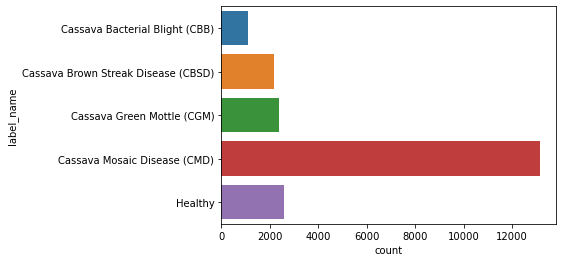

In [4]:
order = ['Cassava Bacterial Blight (CBB)',
         'Cassava Brown Streak Disease (CBSD)',
         'Cassava Green Mottle (CGM)', 
         'Cassava Mosaic Disease (CMD)',
         'Healthy']

print(Train["label_name"].value_counts())

sns.countplot(y = "label_name", 
              data = Train, order = order)

#### 2) picture Finding

In [5]:
import os
import zipfile

local = "Desktop/phthon/cassava-leaf-disease-classification/cassava-leaf-disease-classification (1).zip"
local_sub = "Desktop/phthon/cassava-leaf-disease-classification/cassava-leaf-disease-classification (1)"

zip_ref = zipfile.ZipFile(local)
zip_ref.extractall(local_sub)
train_dir = os.path.join(local_sub, "train_images")

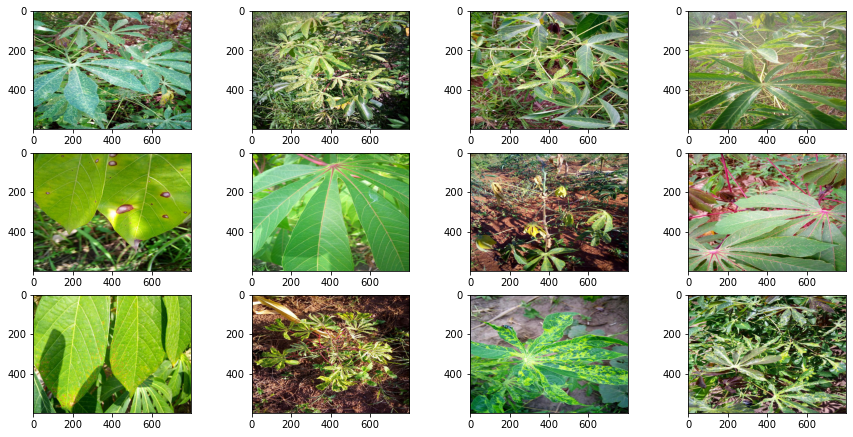

In [8]:
train_pictures = os.listdir(train_dir)
train_pictures_root = [os.path.join(train_dir, i) for i in train_pictures[0:12]]


fig = plt.figure(figsize = [15,10])

for i, image in enumerate(train_pictures_root):
    fig.add_subplot(4,4, i+1)
    plt.imshow(mpimg.imread(image))

### Image load & Data preprocessing

In [213]:
folder = "Desktop/phthon/cassava-leaf-disease-classification/train_images/"
folder_test = "Desktop/phthon/cassava-leaf-disease-classification/test_images/"

#### making the root for convenience
Train["image_id_folder"] = folder + Train["image_id"]
Test["image_id_folder"] = folder_test + Test["image_id"]

In [179]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50

In [184]:
from tensorflow.keras.models import Model

In [231]:
from pathlib import Path
path = Path("Desktop/phthon/cassava-leaf-disease-classification/train_images/") 

In [232]:
def extract_features(image_id, model):
    file = path/image_id
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    
    return features

In [233]:
model = ResNet50()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)


In [234]:
healthy = Train[Train['label']==4]

In [236]:
healthy['features'] = healthy["image_id"].apply(lambda x : extract_features(x,model))

In [7]:
size = round(len(Train) * 0.8)

training_df = shuffle(Train).iloc[ : size]
validation_df = shuffle(Train).iloc[ size :]

print(training_df.shape)
print(validation_df.shape)

(17118, 4)
(4279, 4)


In [8]:
batch_size = 8 
image_size = 512
input_shape = (image_size, image_size, 3)
dropout_rate = 0.4 
classes_to_predict = sorted(Train["label"].unique())

In [102]:
training_data = tf.data.Dataset.from_tensor_slices((training_df["image_id_folder"].values, 
                                                    training_df["label"].values))
validation_data = tf.data.Dataset.from_tensor_slices((validation_df["image_id_folder"].values, 
                                                      validation_df["label"].values))

###
def load_imageANDlabel_from_path(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels = 3)
    img = tf.image.random_crop(img, size = [image_size, image_size, 3]) 
    return img, label

###
AUTOTUNE = tf.data.experimental.AUTOTUNE


# mapping
training_data = training_data.map(load_imageANDlabel_from_path, num_parallel_calls = AUTOTUNE)
validation_data = validation_data.map(load_imageANDlabel_from_path, num_parallel_calls = AUTOTUNE)

# prefetch가 되면 none이 생성된다
training_data_batches = training_data.shuffle(buffer_size = 100).batch(batch_size).prefetch(buffer_size=AUTOTUNE)
validation_data_batches = validation_data.shuffle(buffer_size = 100).batch(batch_size).prefetch(buffer_size=AUTOTUNE)

# argumatation 
data_augmentation_layers = Sequential([layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                                       layers.experimental.preprocessing.RandomRotation(0.25),
                                       layers.experimental.preprocessing.RandomZoom(-0.2, 0)]) #이미지를 0~20%만큼 랜덤으로 축소합니다.

In [19]:
## Transfer learning

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input,Dense

efficientnet = EfficientNetB0(weights='imagenet',
                              include_top = False,
                              input_shape=input_shape,
                              drop_connect_rate = dropout_rate)

# efficientnetb0의 학습을 허용
efficientnet.trainable = True

In [21]:
model = Sequential()

model.add(Input(shape = input_shape))
model.add(data_augmentation_layers)
model.add(efficientnet)
model.add(layers.GlobalAveragePooling2D()) 
model.add(layers.Dropout(dropout_rate)) # 드롭아웃 레이어를 추가
model.add(Dense(len(classes_to_predict), activation="softmax")) 

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 512, 512, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 16, 16, 1280)      4049571   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 6405      
Total params: 4,055,976
Trainable params: 4,013,953
Non-trainable params: 42,023
_________________________________________________________________


In [46]:
from tensorflow.keras.experimental import CosineDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

epochs = 30
batch_size = 8
decay_steps = int(round(len(training_df) / batch_size)) * epochs
cosineDecay = CosineDecay(initial_learning_rate = 0.1, decay_steps = decay_steps, alpha = 0.3)

In [47]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=Adam(cosineDecay), metrics=["accuracy"])

In [56]:
# [ModelCheckpoint]
# https://teddylee777.github.io/tensorflow/keras-%EC%BD%9C%EB%B0%B1%ED%95%A8%EC%88%98-vol-02
# [CosineDecay]
# https://norman3.github.io/papers/docs/bag_of_tricks_for_image_classification.html

callbacks = [ModelCheckpoint(filepath = 'mymodel.h5', monitor='val_loss', save_best_only=True), 
             EarlyStopping(monitor='val_loss', patience = 5, verbose=1)]

In [178]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels = 3)
    img = tf.image.random_crop(img, size= [image_size, image_size, 3])
    img = np.reshape(img, [-1,512,512,3])
    return img

def test_predict(filepath):
    local_image = load_image(filepath)
    predictions = model.predict(local_image)
    final = np.argmax(predictions)
    return final

def predictions_over_image(filepath):
    predictions = []
    for path in filepath:
        predictions.append(test_predict(path))
    return predictions

### Example

In [8]:
from sklearn.model_selection import train_test_split

train, validation = train_test_split(Train, test_size = 0.3, stratify = Train['label_name'])
print(train.shape)
print(validation.shape)

(14977, 3)
(6420, 3)


In [10]:
# 데이터 시간이 너무 오래걸리는 관계로 일부만 뽑아서 씀


train_200 = train.head(200)
validation_100 = validation.head(100)

print(train_200.shape)
print(validation_100.shape)

(200, 3)
(100, 3)


### ImageDataGenerator & generator 

In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator

train_datagen = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')


validation_datagen = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
    rescale=1./255)

In [12]:
# generator

batch_size = 40
size = (800, 600)

train_generator = train_datagen.flow_from_dataframe(
    train_200,
    directory = "Desktop/phthon/cassava-leaf-disease-classification/train_images",
    shuffle = True,
    seed = 40,
    class_mode = 'categorical',
    x_col = 'image_id',
    y_col = 'label_name', ### 
    interpolation = 'nearest',
    batch_size = batch_size,
    target_size = size)
    
    
validation_generator = train_datagen.flow_from_dataframe(
    validation_100,
    directory = "Desktop/phthon/cassava-leaf-disease-classification/train_images",
    shuffle = True,
    seed = 40,
    class_mode = 'categorical',
    x_col = 'image_id',
    y_col = 'label_name', ### 
    interpolation = 'nearest',
    batch_size = batch_size,
    target_size = size)

Found 200 validated image filenames belonging to 5 classes.
Found 100 validated image filenames belonging to 5 classes.


### model making, compile, summary

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
import tensorflow.keras.callbacks


model = Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(800, 600, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2)])

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(train["label"].nunique(), activation = 'softmax'))


model.compile(metrics = ['categorical_accuracy'], 
              optimizer = RMSprop(lr = 0.1),
              loss = "categorical_crossentropy")


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 798, 598, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 399, 299, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 397, 297, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 198, 148, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 196, 146, 128)     73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 98, 73, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 96, 71, 256)       2

### Callback in

In [14]:
class mycallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc') is not None and logs.get('acc') > 0.98):
            print("\n Reached 98% accuracy so cancelling")
            self.model.stop_training = True
            
callbacks = mycallback()
steps_per_epoch = round(train_generator.n / train_generator.batch_size)
validation_steps = round(validation_generator.n / validation_generator.batch_size)

In [17]:
history = model.fit(train_generator, 
                    epochs = 20, 
                    callbacks = [callbacks],
                    validation_data = validation_generator,
                    steps_per_epoch = steps_per_epoch,
                    validation_steps = validation_steps,
                    verbose=2)

Epoch 1/20
5/5 - 92s - loss: 9335450107904.0000 - categorical_accuracy: 0.3150 - val_loss: 8512206.0000 - val_categorical_accuracy: 0.1125
Epoch 2/20
5/5 - 92s - loss: 2328662.7500 - categorical_accuracy: 0.3450 - val_loss: 4299.7983 - val_categorical_accuracy: 0.1250
Epoch 3/20
5/5 - 95s - loss: 905.4102 - categorical_accuracy: 0.3550 - val_loss: 49.0428 - val_categorical_accuracy: 0.1875
Epoch 4/20
5/5 - 76s - loss: 11.9094 - categorical_accuracy: 0.2400 - val_loss: 3.1480 - val_categorical_accuracy: 0.6125
Epoch 5/20
5/5 - 95s - loss: 2.9830 - categorical_accuracy: 0.5450 - val_loss: 2.5399 - val_categorical_accuracy: 0.5875
Epoch 6/20
5/5 - 86s - loss: 1.6512 - categorical_accuracy: 0.5500 - val_loss: 1.9282 - val_categorical_accuracy: 0.5750
Epoch 7/20
5/5 - 91s - loss: 1.2944 - categorical_accuracy: 0.5550 - val_loss: 1.8668 - val_categorical_accuracy: 0.5875
Epoch 8/20
5/5 - 90s - loss: 1.2973 - categorical_accuracy: 0.5550 - val_loss: 1.4878 - val_categorical_accuracy: 0.5875
E

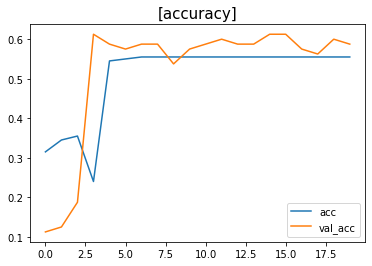

In [20]:
plt.plot(history.history["categorical_accuracy"])
plt.plot(history.history["val_categorical_accuracy"])

plt.title("[accuracy]", fontsize = 15)
plt.legend(["acc", "val_acc"])

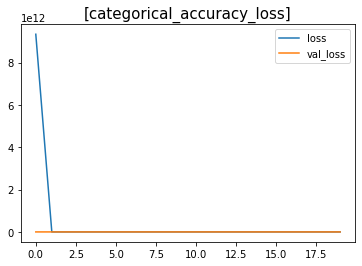

In [21]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

plt.title("[categorical_accuracy_loss]", fontsize = 15)
plt.legend(["loss", "val_loss"])